In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import t as tdist
from scipy.stats import pearsonr

from ar1 import sample_ar1

# Correlation of time series with memory

In this example you will see how to generate an empirical null-distribution for the correlation coefficient between two auto-correlated time series and how to test the correlation coefficient against this null distribution.

In the end you will also see a nice formula to correct for the effect of the auto-correlation without doing a simulation experiment.

First we genrate our "observations", two ramdom time series, that are un-correlated but do exhibit an autocorrelation that would not be uncommon for a climate variable

In [26]:
n = 250
alpha = 0.75
np.random.seed(12358)
y1, y2 = sample_ar1(n, alpha, size=2)

Text(0.5, 0, 'Sample')

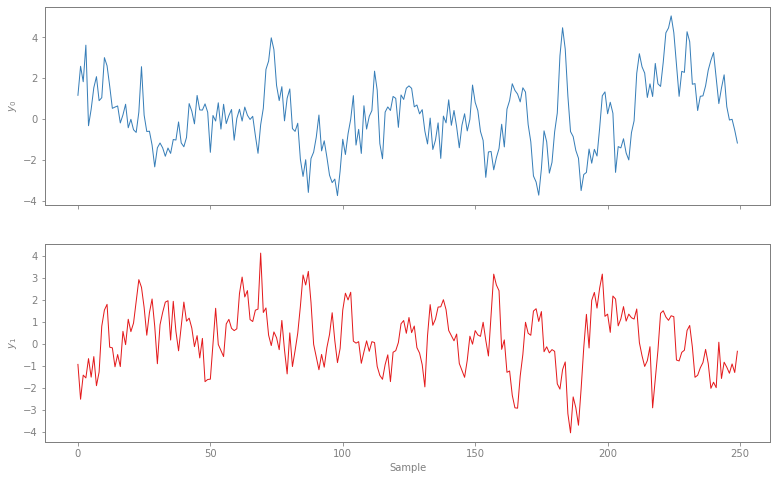

In [27]:
fig, axes = plt.subplots(figsize=(13, 8), nrows=2, sharex=True, sharey=False)

axes[0].plot(y1, 'C0-', lw=1)
axes[0].set_ylabel('$y_0$')
axes[1].plot(y2, 'C1-', lw=1)
axes[1].set_ylabel('$y_1$')

axes[-1].set_xlabel('Sample')

After taking a look at the time series we calculate the correlatrion coefficient between the two time series.

In [7]:
r, p_wn = pearsonr(y1, -1 * y2)
print('r=%.4f (p=%.4f, N=%u)'% (r, p_wn, n))

r=0.2246 (p=0.0003, N=250)


Conveniently, the python function also returns the p-value for the correlation coefficient and it seems that the correlation is highly significant!

## Red noise null distribution

Unfortunately the test assumes white-noise timeseries as the null distribution which is a terrible assumption in this case.

To use a more realistic null-hypothesis we check the correlation coefficient against a null-distribution for auto-correlated time series.

For that we generate a large number of pairs of samples from an AR(1) process with the same number of observations and auto-correlation as our data and calculate the correlation between the two.

We than compare the correlation coefficient against this empirical null-distribution to check at which percentile of the distribution the correlation of our real data is, following the theory that underlies the classical t-test.

In [17]:
nsamples = 20000

sample_r = np.zeros(nsamples)

for i in range(nsamples):
    s1 = sample_ar1(n, alpha)
    s2 = sample_ar1(n, alpha)
    sample_r[i] = pearsonr(s1, s2)[0]

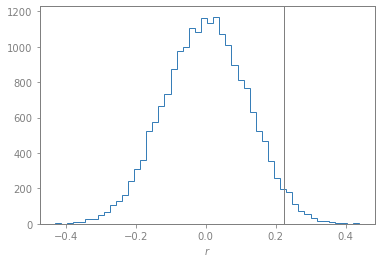

In [25]:
plt.hist(sample_r, bins=50, histtype='step')
plt.xlabel('$r$')
plt.axvline(r)

In [21]:
# Empirical p-value from sampled correlation coefficients
p_empirical = np.mean(np.abs(sample_r) >= np.abs(r))
print('Empirical p-value from simulation: %.4f' % p_empirical)

Empirical p-value from simulation: 0.0568


In the case of simple AR(1) processes, there is a formula that we can use to account for the reduced degrees of freedom due to the autocorrelation:

\begin{align}
    n_\mathrm{eff} = n \frac{1 - \phi_1 \phi_2}{1 + \phi_1 \phi_2}
\end{align}

where $\phi_1$ and $\phi_2$ are the lag-one autocorrelations of the two correlated time series.

You can see below that the autocorrelation of the time series dramatically decreases the effective number of observations!

In [23]:
# Calculate reduced degrees of freedom:
neff = n * (1 - alpha * alpha) / (1 + alpha * alpha)
print('Number of samples: %u' % n)
print('Effective sample size: %u' % neff)

Number of samples: 250
Effective sample size: 70


We can than use this value for the calculation of the t-statistic and for the degrees of freedom of the t-distribution that we check the value agains.

This value agrees well with the empirical value optained above.

In [24]:
# Use reduced number of freedoms to test against theoretical t-distribution
t = r * np.sqrt(neff) / np.sqrt(1 - r**2)
p_theory = 2 * (1 - tdist.cdf(t, neff))
print('Theoretical p-value using reduced DOF: %.4f' % p_theory)

Theoretical p-value using reduced DOF: 0.0578
